# Feature engineering
## TASK 5
### Importing data

In [9]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("train_253253.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()
df = df.asfreq("h")  
df['Demand'] = pd.to_numeric(df['Demand'], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2013-07-01 00:00:00+00:00 to 2014-06-30 23:00:00+00:00
Freq: h
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   pv_mod1                          8321 non-null   float64
 1   pv_mod2                          8268 non-null   float64
 2   pv_mod3                          8249 non-null   float64
 3   Demand                           8759 non-null   float64
 4   pv                               8759 non-null   float64
 5   Price                            8759 non-null   float64
 6   Temperature                      8759 non-null   float64
 7   Pressure (hPa)                   8759 non-null   float64
 8   Cloud_cover (%)                  8759 non-null   float64
 9   Cloud_cover_low (%)              8759 non-null   float64
 10  Cloud_cover_mid (%)              8759 non-null   float64
 11  Cloud_cover_high (%)      

In [10]:
#description of data
stats_table = df[['Demand', 'Temperature', 'Wind_speed_10m (km/h)', 'Cloud_cover (%)']].describe()
print(stats_table)

            Demand  Temperature  Wind_speed_10m (km/h)  Cloud_cover (%)
count  8759.000000  8759.000000            8759.000000      8759.000000
mean      0.530993     7.515413              15.991072        68.704761
std       0.375317     8.312251               7.451494        36.274348
min       0.000000   -18.300000               0.400000         0.000000
25%       0.280000     2.000000              10.400000        39.000000
50%       0.380000     6.800000              15.000000        88.000000
75%       0.660000    14.000000              21.100000       100.000000
max       4.240000    28.900000              51.100000       100.000000


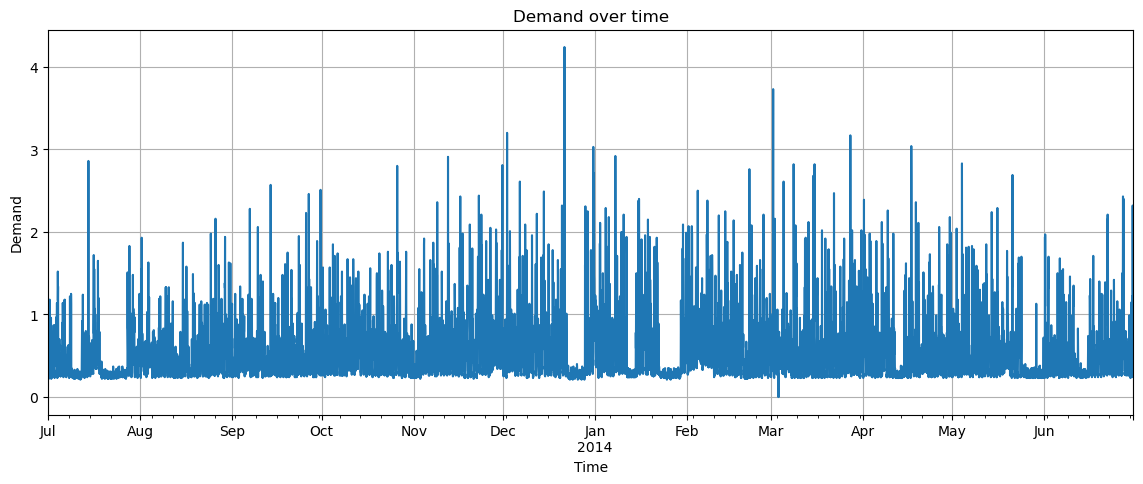

In [11]:
#Demand over time
plt.figure(figsize=(14,5))
df['Demand'].plot()
plt.title("Demand over time")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.grid(True)
plt.show()

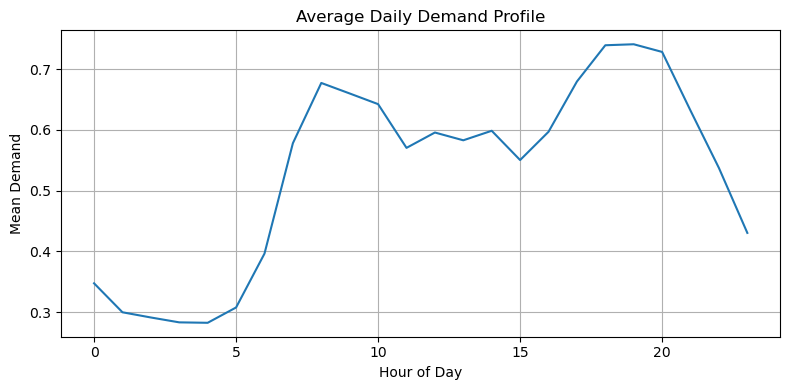

In [12]:
#Average Daily Demand Profile
df['hour'] = df.index.hour
avg_daily = df.groupby('hour')['Demand'].mean()

plt.figure(figsize=(8,4))
plt.plot(avg_daily.index, avg_daily.values)
plt.title("Average Daily Demand Profile")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Demand")
plt.grid(True)
plt.tight_layout()
plt.show()

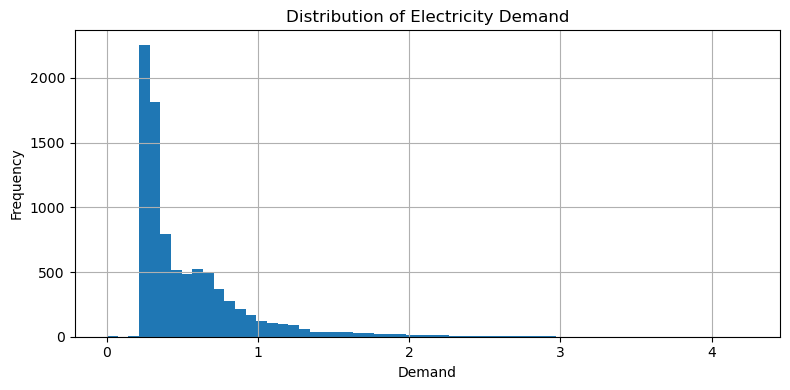

In [13]:
#Distribution of Electricity Demand chart
plt.figure(figsize=(8,4))
plt.hist(df['Demand'].dropna(), bins=60)
plt.title("Distribution of Electricity Demand")
plt.xlabel("Demand")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

## Task 5.2

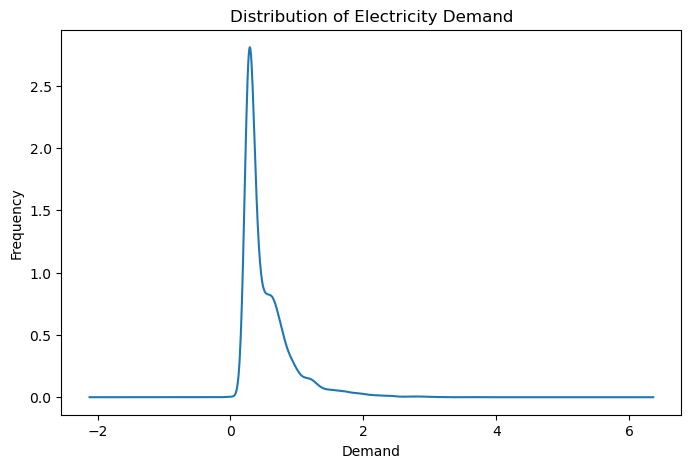

In [35]:
#Distribution of Electricity Demand graph
fig_dens_res = plt.figure(figsize=(8,5))
df['Demand'].plot(title="Distribution of Electricity Demand", kind='kde')
plt.xlabel("Demand")
plt.ylabel("Frequency")
plt.show()

In [38]:
#P-value, without statis original data
stat, p_value = stats.shapiro(df['Demand'].dropna())
print("Shapiro p-value:", p_value)

Shapiro p-value: ShapiroResult(statistic=0.736811871235862, pvalue=1.7485153227830937e-79)


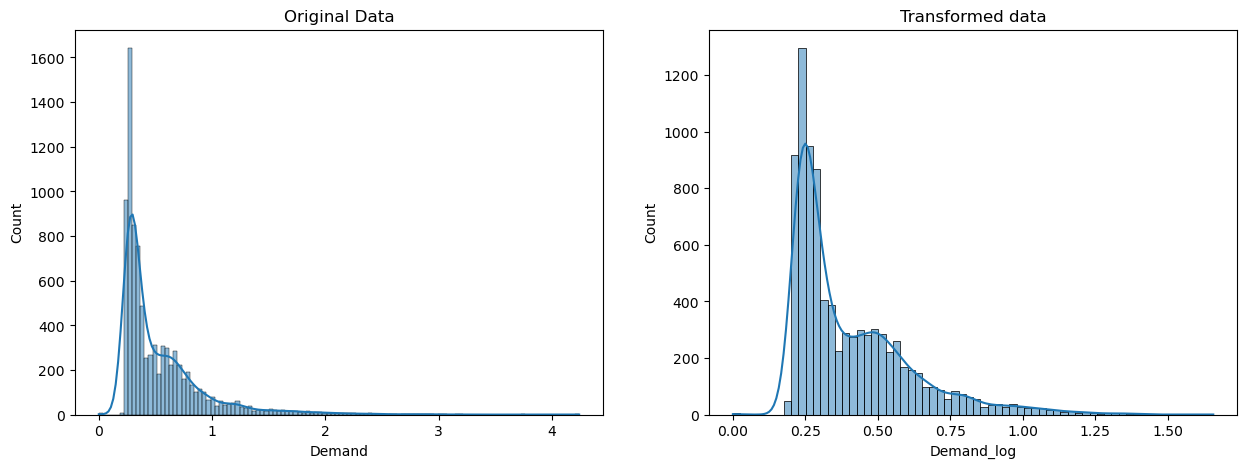

In [39]:
#different transformations
df["Demand_log"] = np.log1p(df["Demand"])
df["Demand_sqrt"] = np.sqrt(df["Demand"])
df["Demand_exp"] = np.exp(df["Demand"])

#testing log transformation
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['Demand'], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(df['Demand_log'], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Transformed data")
plt.show()

In [31]:
#P-value, without statis of log data
stat, p_value = stats.shapiro(df['Demand_log'].dropna())
print("After log transform p-value:", p_value)

After log transform p-value: 3.714070861917199e-70


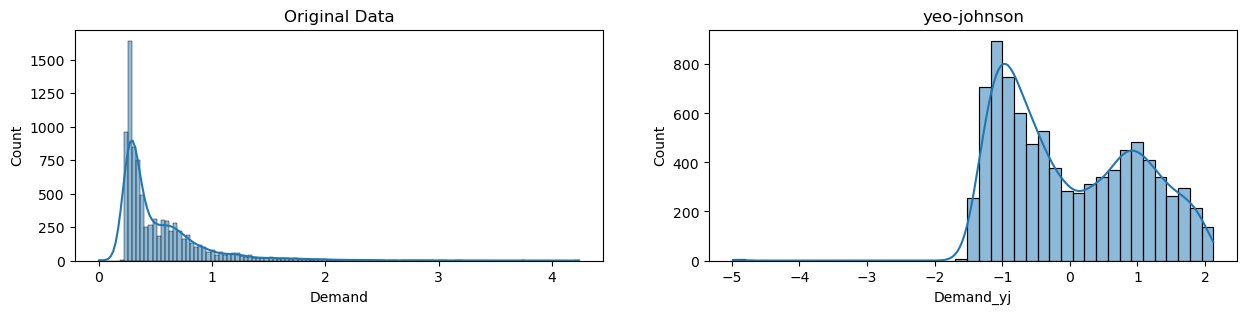

In [32]:
# testing yeo-johnson method
pt_yj = PowerTransformer(method='yeo-johnson')
df['Demand_yj'] = pt_yj.fit_transform(df[['Demand']])

# plot both together to compare
fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(df['Demand'], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(df['Demand_yj'], ax=ax[1], kde=True, legend=False)
ax[1].set_title("yeo-johnson")
plt.show()


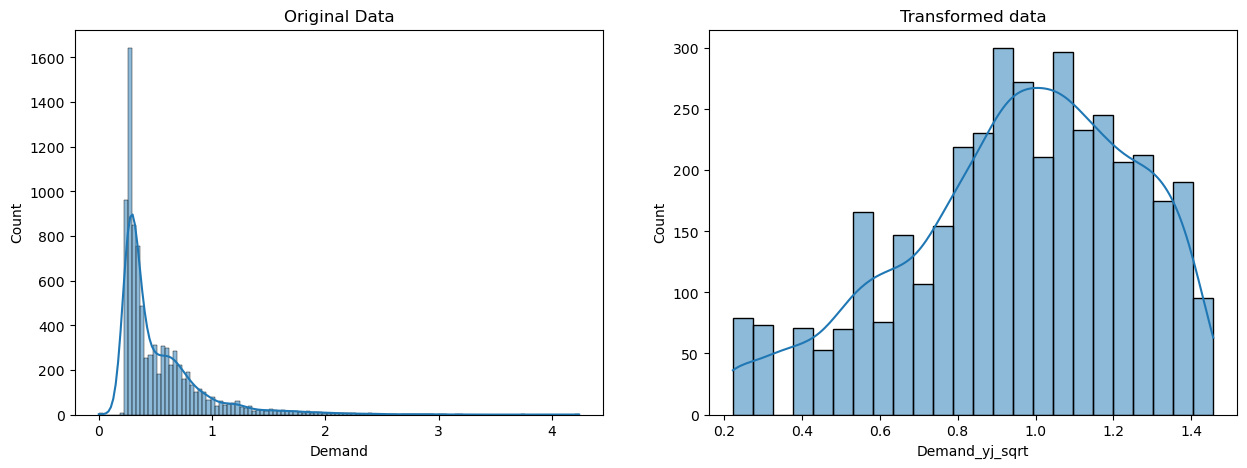

In [33]:
#different transformations
df["Demand_yj_log"] = np.log1p(df["Demand_yj"])
df["Demand_yj_sqrt"] = np.sqrt(df["Demand_yj"])
df["Demand_yj_exp"] = np.exp(df["Demand_yj"])

#adding root sqrt over yeo-johnson transformation
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['Demand'], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(df['Demand_yj_sqrt'], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Transformed data")
plt.show()

In [34]:
#P-value, without statis original data
tat, p_value = stats.shapiro(df['Demand_yj_sqrt'].dropna())
print("After log transform p-value:", p_value)

After log transform p-value: 4.7908945991858354e-29


## Task 5.3

In [40]:
#Time-based Features

# cyclic hour coding
df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)

# working hour load
df['working_hour_load'] = (
    (df.index.hour >= 8) &
    (df.index.hour <= 18) &
    (df.index.dayofweek < 5)
).astype(int)

df[['hour_sin', 'hour_cos', 'working_hour_load']].head()


,hour_sin,hour_cos,working_hour_load
timestamp,,,
2013-07-01 00:00:00+00:00,0.000000,1.000000,0
2013-07-01 01:00:00+00:00,0.258819,0.965926,0
2013-07-01 02:00:00+00:00,0.500000,0.866025,0
2013-07-01 03:00:00+00:00,0.707107,0.707107,0
2013-07-01 04:00:00+00:00,0.866025,0.500000,0


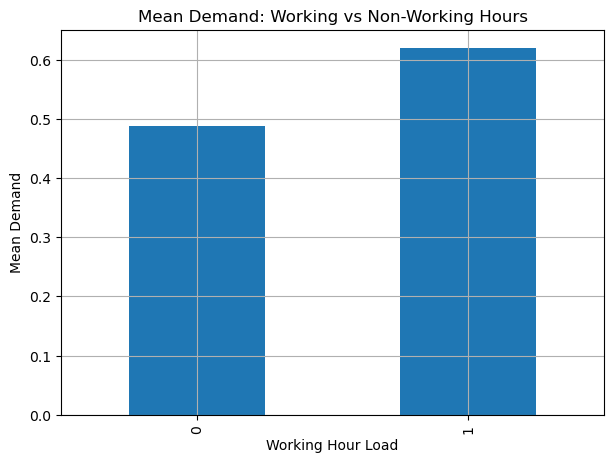

In [42]:
#plotting working_hour_load
plt.figure(figsize=(7,5))
df.groupby('working_hour_load')['Demand'].mean().plot(kind='bar')
plt.title("Mean Demand: Working vs Non-Working Hours")
plt.xlabel("Working Hour Load")
plt.ylabel("Mean Demand")
plt.grid(True)
plt.show()

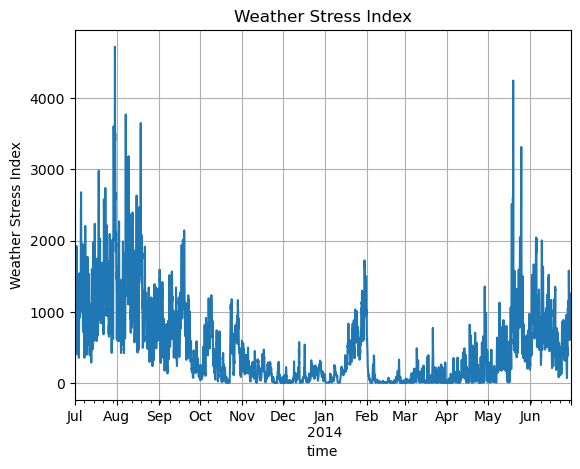

In [43]:
#Weather-based Feature
df['weather_stress_index'] = (
    (df['Temperature'] ** 2) *
    (1 + df['Cloud_cover (%)'] / 100) *
    (1 + df['Wind_speed_10m (km/h)'] / 10)
)

df[['weather_stress_index']].describe()
df['weather_stress_index'].plot()
plt.title("Weather Stress Index")
plt.xlabel("time")
plt.ylabel("Weather Stress Index")
plt.grid(True)
plt.show()

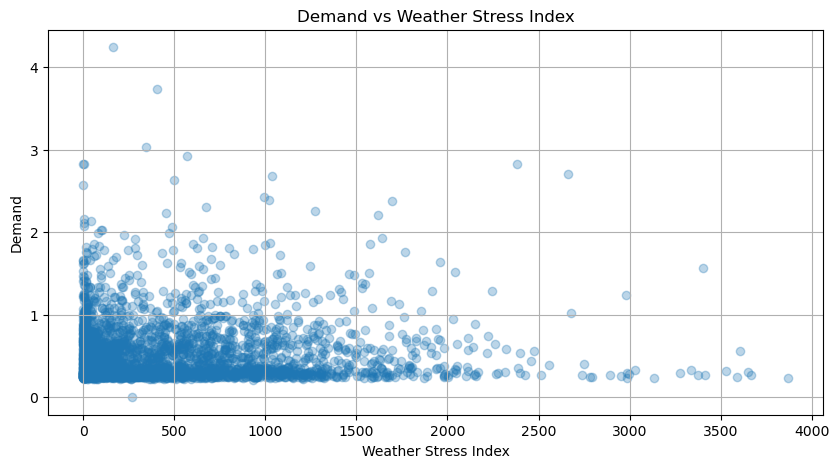

In [46]:
# another plot with new feature
plt.figure(figsize=(10,5))
plt.scatter(
    df['weather_stress_index'].sample(3000),
    df['Demand'].sample(3000),
    alpha=0.3
)
plt.title("Demand vs Weather Stress Index")
plt.xlabel("Weather Stress Index")
plt.ylabel("Demand")
plt.grid(True)
plt.show()

## Task 5.4

In [47]:
features = [
    'Temperature',
    'Wind_speed_10m (km/h)',
    'Cloud_cover (%)',
    'hour_sin',
    'hour_cos',
    'working_hour_load',
    'weather_stress_index'
]

df_model = df[features + ['Demand']].dropna()

X = df_model[features]
y = df_model['Demand']

model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X, y)
#fearuses relevance
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

# table
feature_ranking = importances.reset_index()
feature_ranking.columns = ['Feature', 'Importance']

print(feature_ranking)


                 Feature  Importance
0   weather_stress_index    0.239018
1  Wind_speed_10m (km/h)    0.218154
2            Temperature    0.168919
3               hour_cos    0.128384
4               hour_sin    0.114820
5        Cloud_cover (%)    0.112160
6      working_hour_load    0.018544
